### <a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# calwebb_ami3, ami_average

<span style="color:red"> **Instruments Affected**</span>: NIRISS

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction\*](#intro)
<br> [JWST CalWG Algorithm\*](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description\*](#description)
<br> [Data Description\*](#data_descr)
<br> [Imports\*](#imports)
<br> [Loading the Data\*](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests or Visualization](#testing) 
<br> [About This Notebook\*](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This is the validation notebook for the AMI average step. This step averages the results of LG processing from the ami_analyze step for multiple exposures of a given target. It computes a simple average for all 8 components of the “ami” product files from all input exposures. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/ami_average/index.html

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/ami/ami_average.py


[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm


Confluence page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Average+Fringe+Params


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

* **JWST**: James Webb Space Telescope
* **NIRISS**: Near-Infrared Imager and Slitless Spectrograph
* **AMI**: Aperture Masking Interferometry (NIRISS observing mode)
* **LG**: Lacour-Greenbaum image plane modeling algorithm [(Greenbaum et al. 2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...798...68G/abstract)
* **Interferometric observables**: quantities extracted from interferograms that describe the phase and visibility of the object
* **OIFITS**: Optical Interferometry Flexible Image Transport System; file format used of optical interferometry


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test is performed by comparing interferometric observables from multiple exposures averaged together by the pipeline step to those averaged together manually. The data are first calibrated through the Detector1, Image 2, and AMI3 ami_analyze (observable extraction) steps. We use multiple 'ami_analyze.fits' products as the starting point, and produce a single 'amiaveragestep.fits' product. While all eight data extensions of the input files are currently averaged, we are mainly interested in the four observable extensions: closure phase, closure amplitude, visibility phase, and visibility amplitude, as well as the pupil phases and fringe coefficients extensions. We test that each element of the pipeline-averaged arrays of each of these observables is equal to within $1\times 10^{-6}$ to the same element in the manually-averaged array of observables.


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The data used for this test were created with MIRAGE (Multi-Instrument RAmp GEnerator). The data set contains simulated observations of **AB Dor** (a known binary system) and **HD-37093** (a suitable calibration star) in filter F480M at four primary dither positions. These simulations do not contain bad pixels. For this test, we use two exposures of AB Dor at dither positions 2 and 3, which are cropped to 35 x 35 pixels. 


Outputs of any of the three AMI3 pipeline steps have the following structure:
1. FIT: a 2D image of the fitted model
2. RESID: a 2D image of the fit residuals
3. CLOSURE_AMP: table of closure amplitudes
4. CLOSURE_PHA: table of closure phases
5. FRINGE_AMP: table of fringe amplitudes
6. FRINGE_PHA: table of fringe phases
7. PUPIL_PHA: table of pupil phases
8. SOLNS: table of fringe coefficients

**Note:** Observations at different dither positions are trimmed to different dimensions depending on their location on the SUB80 detector subarray, and the AMI3 pipeline currently crashes if input files have image extensions with different dimensions. Therefore we must currently make sure that the 'FIT' and 'RESID' extensions of the input files have the same dimensions before averaging.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [ ]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

## If Desired, set up CRDS to use a local cache

By default, the notebook template environment sets up its CRDS cache (the "CRDS_PATH" environment variable) in /grp/crds/cache. However, if the notebook is running on a local machine without a fast and reliable connection to central storage, it makes more sense to put the CRDS cache locally. Currently, the cell below offers several options, and will check the supplied boolean variables one at a time until one matches.

* if `use_local_crds_cache` is False, then the CRDS cache will be kept in /grp/crds/cache
* if `use_local_crds_cache` is True, the CRDS cache will be kept locally
  * if `crds_cache_tempdir` is True, the CRDS cache will be kept in the temporary directory
  * if `crds_cache_notebook_dir` is True, the CRDS cache will be kept in the same directory as the notebook.
  * if `crds_cache_home` is True, the CRDS cache will be kept in $HOME/crds/cache
  * if `crds_cache_custom_dir` is True, the CRDS cache will be kept in whatever is stored in the 
    `crds_cache_dir_name` variable.

If the above cell (creating a temporary directory) is not run, then setting `crds_cache_tempdir` to True will store the CRDS cache in the notebook's directory (the same as setting `crds_cache_notebook_dir` to True).

In [ ]:
import os

# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = False
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* os for interacting with the operating system
* numpy for array handling
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.ami.AmiAverageStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [1]:
# import inspect
import os
import numpy as np
from astropy.io import fits
from jwst.pipeline import Detector1Pipeline, Image2Pipeline
from jwst.ami import AmiAnalyzeStep, AmiAverageStep
import matplotlib.pyplot as plt
from ci_watson.artifactory_helpers import get_bigdata


<a id="data_load"></a>
# Loading the Data

Load the data from Artifactory (for internal use only)

[Top of Page](#title_ID)

In [ ]:

# Get uncalibrated data files
datafiles = []
file = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jw01093001001_01101_00006_nis_uncal.fits')
datafiles.append(file)
file = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jw01093001001_01101_00007_nis_uncal.fits')
datafiles.append(file)

# Get non-standard reference files and AMI3 config file
superbiasfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_superbias_sim.fits')
darkfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_dark_sub80_sim.fits')

flatfieldfile = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'jwst_niriss_flat_general.fits')
ami_config = get_bigdata('jwst_validation_notebooks',
                'validation_data',
                'ami_analyze',
                'ami_analyze.cfg')

# Run Detector1, Image2, ami_analyze

Start with `uncal.fits` files and run the Detector1 pipeline, skipping the IPC correction and overriding the dark and superbias reference files (necessary because of simulations generated without bad pixels).

Then run the Image2 pipeline, skipping the photometry and resample steps, and using a non-default flat field reference file, to produce `cal.fits` products.

Then run the AMI3 ami_analyze step on each `cal.fits` file.

In [ ]:
# Run Detector1, Image 2 pipelines, run ami_analyze on cropped data
odir = os.getcwd()
print('All output files will be saved to %s' % odir)

for df in uncalfiles:
    result1 = Detector1Pipeline()
    result1.superbias.override_superbias = superbiasfile
    result1.dark_current.override_dark = darkfile
    result1.ipc.skip = True
    result1.save_results = True
    result1.output_dir = odir
    result1.run(df)
            
    df_rate = os.path.join(odir,os.path.basename(df.replace('uncal','rate')))
    result2 = Image2Pipeline()        
    result2.flat_field.override_flat = flatfieldfile
    result2.photom.skip = True
    result2.resample.skip = True
    result2.save_results = True
    result2.output_dir = odir
    result2.run(df_rate)

    df_rateints = os.path.join(odir,os.path.basename(df.replace('uncal','rateints')))
    result3 = Image2Pipeline()
    result3.flat_field.override_flat = flatfieldfile
    result3.photom.skip = True
    result3.resample.skip = True
    result3.save_results = True
    result3.output_dir = odir
    result3.run(df_rateints)        
    
    df_cal = os.path.join(odir,os.path.basename(df.replace('uncal','cal')))
    print("Generated calibrated files", df_cal)  

    #Run ami_analyze on _cal.fits files
    result4 = AmiAnalyzeStep.call(df_cal, config_file='ami_analyze.cfg',output_dir=odir, save_results=True)

### Examine the ami_analyze file structure

In [77]:
infiles = glob.glob('*ami_analyze.fits')

for file in infiles:
    fits.info(file)
    print('\n')

Filename: files/jw01093001001_01101_00006_nis_ami_analyze.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  FIT           1 ImageHDU         9   (35, 35)   float32   
  2  RESID         1 ImageHDU         9   (35, 35)   float32   
  3  CLOSURE_AMP    1 BinTableHDU     12   35R x 1C   [D]   
  4  CLOSURE_PHA    1 BinTableHDU     12   35R x 1C   [D]   
  5  FRINGE_AMP    1 BinTableHDU     12   21R x 1C   [D]   
  6  FRINGE_PHA    1 BinTableHDU     12   21R x 1C   [D]   
  7  PUPIL_PHA     1 BinTableHDU     12   7R x 1C   [D]   
  8  SOLNS         1 BinTableHDU     12   44R x 1C   [D]   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [6007B]   


Filename: files/jw01093001001_01101_00007_nis_ami_analyze.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  FIT           1 ImageHDU         9   (35, 35)   float32   
  2  RESID         1 ImageHDU 

<a id="pipeline"></a>
# Run the AmiAverage Step

Run the AMI3 AmiAverage step on the two 'ami_analyze.fits' files. First, create the base of the output filename from one of the input filenames (the output name will have 'amiaveragestep.fits' appended automatically)

In [23]:
basename = os.path.basename(infiles[0]).split('_ami_analyze', 1)[0]

amiavg = AmiAverageStep.call(infiles, save_results=True, output_file=basename)

2021-05-26 18:11:03,185 - stpipe.AmiAverageStep - INFO - AmiAverageStep instance created.
2021-05-26 18:11:03,248 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep running with args (['files/jw01093001001_01101_00006_nis_ami_analyze.fits', 'files/jw01093001001_01101_00007_nis_ami_analyze.fits'],).
2021-05-26 18:11:03,251 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/user/rcooper/Projects/NIRISS/AMI/jwst_validation_notebooks/jwst_validation_notebooks/ami3/jw01093001001_01101_00006_nis', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-05-26 18:11:03,847 - stpipe.AmiAverageStep - INFO - Saved model in jw01093001001_01101_00006_nis_amiaveragestep.fits
2021-05-26 18:11:03,848 - stpipe.AmiAverageStep - INFO - Step AmiAverageStep done


<a id="testing"></a>
# Perform Tests or Visualization

Perform the validation tests described previously. Generate plots, tables, diagnostics, etc. 

[Top of Page](#title_ID)

### Load the ami_average product

We will only be using the averaged interferometric observables: closure phase, closure amplitude, fringe phase, and fringe amplitude, as well as the pupil phase and fringe coefficients ('SOLNS' extension). First, define a function to read in all the relevant extensions.

In [22]:
def read_ami(fn):
    with fits.open(fn) as hdu1:
        CA = hdu1['CLOSURE_AMP'].data.astype(np.float64)
        CP = hdu1['CLOSURE_PHA'].data.astype(np.float64)
        FA = hdu1['FRINGE_AMP'].data.astype(np.float64)
        FP = hdu1['FRINGE_PHA'].data.astype(np.float64)
        PP = hdu1['PUPIL_PHA'].data.astype(np.float64)
        soln = hdu1['SOLNS'].data.astype(np.float64)
    return CA, CP, FA, FP, PP, soln

In [23]:
amiavgfile = 'jw01093001001_01101_00006_nis_amiaveragestep.fits'

CA_pipe, CP_pipe, FA_pipe, FP_pipe, PP_pipe, soln_pipe = read_ami(amiavgfile)


print('%i Closure Phases' % len(CP_pipe))
print('%i Closure Amplitudes' % len(CA_pipe))
print('%i Fringe Phases' % len(FP_pipe))
print('%i Fringe Amplitudes' % len(FA_pipe))
print('%i Pupil Phases' % len(PP_pipe))
print('%i Fringe Coeffs' % len(soln_pipe))

35 Closure Phases
35 Closure Amplitudes
21 Fringe Phases
21 Fringe Amplitudes
7 Pupil Phases
44 Fringe Coeffs


### Manually average observables from input files

Load the observables from each file into lists, and take the mean of the observable arrays across the exposures, preserving the length of each array.

In [24]:
CPs = []
CAs = []
FPs = []
FAs = []
PPs = []
solns = []
for fn in infiles:
    CA, CP, FA, FP, PP, soln = read_ami(fn)
    CAs.append(CA)
    CPs.append(CP)
    FAs.append(FA)
    FPs.append(FP)
    PPs.append(PP)
    solns.append(soln)

CP_man = np.mean(CPs, axis=0)
CA_man = np.mean(CAs, axis=0)
FP_man = np.mean(FPs, axis=0)
FA_man = np.mean(FAs, axis=0)
PP_man = np.mean(PPs, axis=0)
soln_man = np.mean(solns, axis=0)

### Test the agreement

Test if the pipeline-avergaed and manually-averaged observables are equal, to within a tolerance of $1\times 10^{-6}$

In [25]:
rtol=0.0 # relative tolerance
atol=1e-6 # absolute tolerance
print('\n Closure phases:',np.allclose(CP_pipe,CP_man,rtol,atol),'\n',
     'Closure amplitudes:',np.allclose(CA_pipe,CA_man,rtol,atol),'\n',
     'Fringe phases:',np.allclose(FP_pipe,FP_man,rtol,atol),'\n',
     'Fringe amplitudes:',np.allclose(FA_pipe,FA_man,rtol,atol),'\n',
     'Pupil phases:',np.allclose(PP_pipe,PP_man,rtol,atol),'\n',
     'Fringe coefficients:',np.allclose(soln_pipe,soln_man,rtol,atol),'\n',)


 Closure phases: True 
 Closure amplitudes: True 
 Fringe phases: True 
 Fringe amplitudes: True 
 Pupil phases: True 
 Fringe coefficients: True 



### Visualize the difference
Plot the two averaged sets of observables. If the observables were averaged correctly, the points should lie on top of each other:

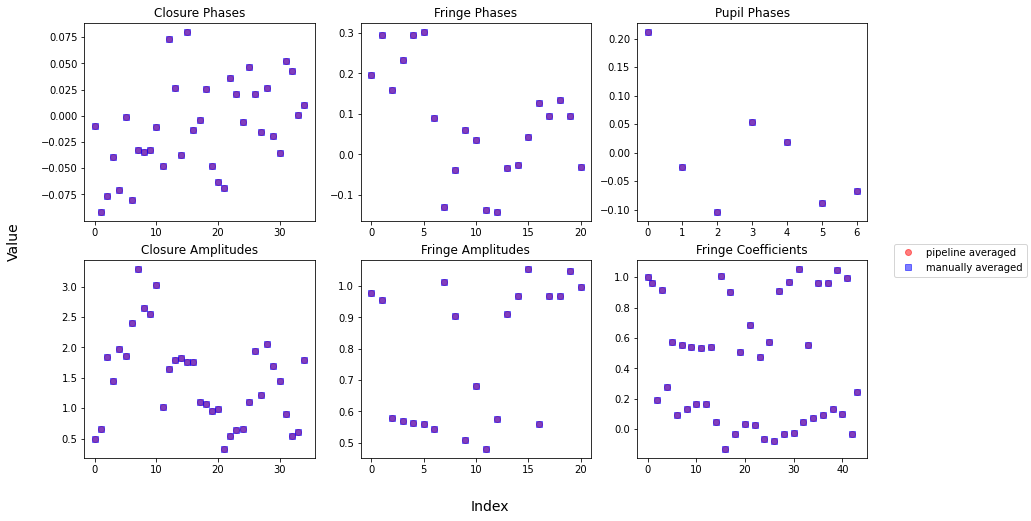

In [26]:
n_closure = np.arange(len(CP_pipe))
n_fringe = np.arange(len(FP_pipe))
n_pup = np.arange(len(PP_pipe))
n_soln = np.arange(len(soln_pipe))

fig, axs = plt.subplots(2,3, figsize=(15,8))
axs[0][0].plot(n_closure,CP_pipe,'ro', alpha=.5, label='pipeline averaged')
axs[0][0].plot(n_closure,CP_man,'bs', alpha=.5, label='manually averaged')
axs[0][0].plot((n_closure,n_closure),(CP_pipe,CP_man),c='black',linewidth=.5)
axs[0][0].set_title('Closure Phases')

axs[0][1].plot(n_fringe,FP_pipe,'ro', alpha=.5)
axs[0][1].plot(n_fringe,FP_man,'bs', alpha=.5)
axs[0][1].plot((n_fringe,n_fringe),(FP_pipe,FP_man),c='black',linewidth=.5)
axs[0][1].set_title('Fringe Phases')

axs[0][2].plot(n_pup,PP_pipe,'ro', alpha=.5)
axs[0][2].plot(n_pup,PP_man,'bs', alpha=.5)
axs[0][2].plot((n_pup,n_pup),(PP_pipe,PP_man),c='black',linewidth=.5)
axs[0][2].set_title('Pupil Phases')

axs[1][0].plot(n_closure,CA_pipe,'ro', alpha=.5)
axs[1][0].plot(n_closure,CA_man,'bs', alpha=.5)
axs[1][0].plot((n_closure,n_closure),(CA_pipe,CA_man),c='black',linewidth=.5)
axs[1][0].set_title('Closure Amplitudes')

axs[1][1].plot(n_fringe,FA_pipe,'ro', alpha=.5)
axs[1][1].plot(n_fringe,FA_man,'bs', alpha=.5)
axs[1][1].plot((n_fringe,n_fringe),(FA_pipe,FA_man),c='black',linewidth=.5)
axs[1][1].set_title('Fringe Amplitudes')

axs[1][2].plot(n_soln,soln_pipe,'ro', alpha=.5)
axs[1][2].plot(n_soln,soln_man,'bs', alpha=.5)
axs[1][2].plot((n_soln,n_soln),(soln_pipe,soln_man),c='black',linewidth=.5)
axs[1][2].set_title('Fringe Coefficients')

fig.text(0.5, 0.04, 'Index', ha='center', va='center', size=14)
fig.text(0.06, 0.5, 'Value', ha='center', va='center', rotation='vertical', size=14)
fig.legend(loc=7)
fig.subplots_adjust(right=0.85)   

Visualize the difference between the sets of averaged observables, if any:

Text(0.06, 0.5, 'Difference')

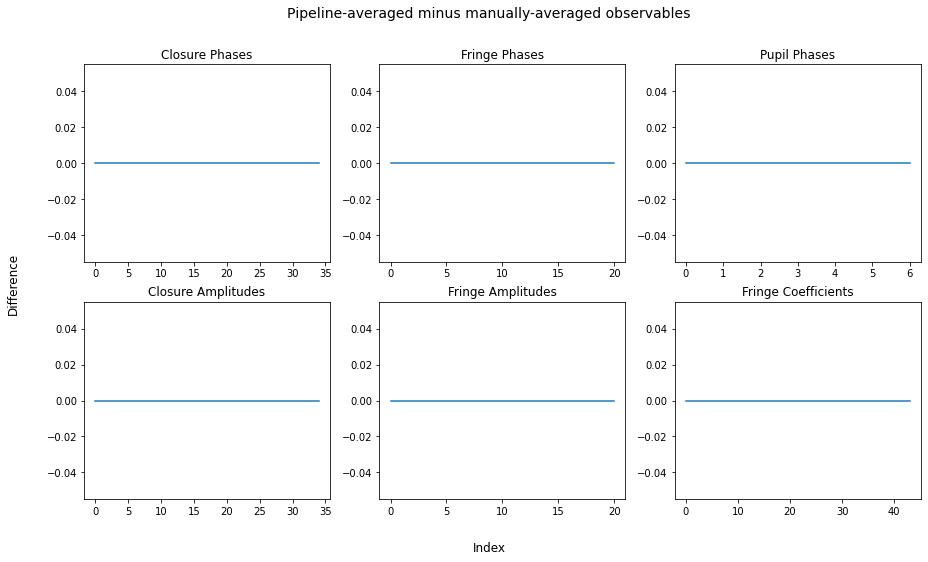

In [20]:
fig, axs = plt.subplots(2,3, figsize=(15,8))
plt.suptitle('Pipeline-averaged minus manually-averaged observables', size=14)
axs[0][0].plot(n_closure,CP_pipe - CP_man)
axs[0][0].set_title('Closure Phases')

axs[0][1].plot(n_fringe,FP_pipe - FP_man)
axs[0][1].set_title('Fringe Phases')

axs[0][2].plot(n_pup,PP_pipe - PP_man)
axs[0][2].set_title('Pupil Phases')

axs[1][0].plot(n_closure,CA_pipe - CA_man)
axs[1][0].set_title('Closure Amplitudes')

axs[1][1].plot(n_fringe,FA_pipe - FA_man)
axs[1][1].set_title('Fringe Amplitudes')

axs[1][2].plot(n_soln,soln_pipe - soln_man)
axs[1][2].set_title('Fringe Coefficients')

fig.text(0.5, 0.04, 'Index', ha='center', va='center', size=12)
fig.text(0.06, 0.5, 'Difference', ha='center', va='center', rotation='vertical', size=12)

<a id="about_ID"></a>
## About this Notebook
**Author:** Rachel Cooper, Science Support Analyst, ISSB/NIRISS
<br>**Updated On:** MM/DD/YYYY

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 